**Lecture 5: Classification with Perceptron Model**

In [3]:
%matplotlib inline
import os
import time
import tqdm
import torch
import pickle
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader

print(torch.__version__) # This code has been updated for PyTorch 1.0.0


savePath = 'lecture5_output/'
if not os.path.isdir(savePath):
    os.makedirs(savePath)

1.13.1+cu116


**Loading saved features from disk**

In [5]:
# Loading the saved features
with open("trainFeats.pckl", "rb") as f:
    trainFeats = pickle.load(f)
with open("trainLabel.pckl", "rb") as f:
    trainLabel = pickle.load(f)
    
with open("testFeats.pckl", "rb") as f:
    testFeats = pickle.load(f)
with open("testLabel.pckl", "rb") as f:
    testLabel = pickle.load(f)
    
print('Finished loading saved feature matrices from the disk!')

Finished loading saved feature matrices from the disk!


**Defining network architecture**

In [6]:
# Defining the perceptron
class perceptron(nn.Module):
    def __init__(self,n_channels): #n_channels => length of feature vector
        super(perceptron, self).__init__()
        self.L = nn.Linear(n_channels,10) #Mapping from input to output
    def forward(self,x): #x => Input
        x = self.L(x) #Feed-forward  
        x = F.softmax(x,dim=1) #Softmax non-linearity, dim=1 corresponds to labels
        return x

In [7]:
# Generating 1-hot label vectors
trainLabel2 = np.zeros((50000,10))
testLabel2 = np.zeros((10000,10))
for d1 in range(trainLabel.shape[0]):
    trainLabel2[d1,trainLabel[d1]] = 1
for d2 in range(testLabel.shape[0]):
    testLabel2[d2,testLabel[d2]] = 1

In [8]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
    pinMem = True
else:
    print('GPU is not available!')
    device = "cpu"
    pinMem = False

GPU is available!


**Dataset preparation**

In [9]:
# Creating pytorch dataset from the feature matices
trainDataset = TensorDataset(torch.from_numpy(trainFeats), torch.from_numpy(trainLabel2))
testDataset = TensorDataset(torch.from_numpy(testFeats), torch.from_numpy(testLabel2))
# Creating dataloader
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=pinMem)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=False,num_workers=4, pin_memory=pinMem)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Defining function for training the network**

In [10]:
# Definining the training routine
def train_model(model,criterion,num_epochs,learning_rate):
        start = time.time()
        train_loss = [] #List for saving the loss per epoch    
        train_acc = [] #List for saving the accuracy per epoch  
        tempLabels = [] #List for saving shuffled labels as fed into the network
        for epoch in range(num_epochs):
            epochStartTime = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))

            running_loss = 0.0           
            # Loading data in batches
            batch = 0
            for data in tqdm.tqdm_notebook(trainLoader):
                inputs,labels = data
                
                inputs, labels = inputs.float().to(device),labels.float().to(device)
                
                # Initializing model gradients to zero
                model.zero_grad() 
                # Data feed-forward through the network
                outputs = model(inputs)
                # Predicted class is the one with maximum probability
                _, preds = outputs.data.max(1)                 
                # Finding the MSE
                loss = criterion(outputs, labels)
                # Accumulating the loss for each batch
                running_loss += loss.item()          
    
                # Backpropaging the error
                if batch == 0:
                    totalLoss = loss
                    totalPreds = preds                    
                    tempLabels = labels.data.cpu()
                    batch += 1                    
                else:
                    totalLoss += loss 
                    totalPreds = torch.cat((totalPreds,preds),0)                 
                    tempLabels = torch.cat((tempLabels,labels.data.cpu()),0)
                    batch += 1
                    
            totalLoss = totalLoss/batch
            totalLoss.backward()
            
            # Updating the model parameters
            for f in model.parameters():
                f.data.sub_(f.grad.data * learning_rate) 
                                    
            epoch_loss = running_loss/50000  #Total loss for one epoch
            train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
            
            # Accuracy per epoch
            tempLabels = tempLabels.numpy()
            _,totalLabels = np.where(tempLabels==1)                        
            epoch_acc = np.sum(np.equal(totalPreds.cpu().numpy(),np.array(totalLabels)))/50000.0      
            train_acc.append(epoch_acc*100) #Saving the accuracy over epochs for plotting the graph
            
            epochTimeEnd = time.time()-epochStartTime
            print('Average epoch loss: {:.6f}'.format(epoch_loss))
            print('Average epoch accuracy: {:.4f} %'.format(epoch_acc*100))
            print('-' * 25)
            # Plotting Loss vs Epochs
            fig1 = plt.figure(1)        
            plt.plot(range(epoch+1),train_loss,'r--',label='train')      
            if epoch == 0:
                plt.legend(loc='upper right')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Plot of training loss vs epochs')
            fig1.savefig(savePath+'lossPlot.png')
             # Plotting Accuracy vs Epochs
            fig2 = plt.figure(2)        
            plt.plot(range(epoch+1),train_acc,'g--',label='train')  
            if epoch == 0:
                plt.legend(loc='upper left')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.title('Plot of training accuracy vs epochs')
            fig2.savefig(savePath+'accPlot.png')

        time_elapsed = time.time() - start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        return model

**Training the perceptron**

Epoch 0/199


<ipython-input-10-c695a2ccecdc>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm.tqdm_notebook(trainLoader):


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001423
Average epoch accuracy: 10.0200 %
-------------------------
Epoch 1/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001422
Average epoch accuracy: 10.0180 %
-------------------------
Epoch 2/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001422
Average epoch accuracy: 10.0200 %
-------------------------
Epoch 3/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001422
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 4/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001422
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 5/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001422
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 6/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001422
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 7/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0200 %
-------------------------
Epoch 8/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0200 %
-------------------------
Epoch 9/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 10/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 11/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 12/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 13/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001421
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 14/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 15/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0280 %
-------------------------
Epoch 16/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0340 %
-------------------------
Epoch 17/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0340 %
-------------------------
Epoch 18/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0360 %
-------------------------
Epoch 19/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0320 %
-------------------------
Epoch 20/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0260 %
-------------------------
Epoch 21/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 22/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001420
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 23/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 24/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0200 %
-------------------------
Epoch 25/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 26/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0220 %
-------------------------
Epoch 27/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 28/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0240 %
-------------------------
Epoch 29/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0260 %
-------------------------
Epoch 30/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0320 %
-------------------------
Epoch 31/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001419
Average epoch accuracy: 10.0340 %
-------------------------
Epoch 32/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0380 %
-------------------------
Epoch 33/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0440 %
-------------------------
Epoch 34/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0440 %
-------------------------
Epoch 35/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0380 %
-------------------------
Epoch 36/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0360 %
-------------------------
Epoch 37/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0420 %
-------------------------
Epoch 38/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0420 %
-------------------------
Epoch 39/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0460 %
-------------------------
Epoch 40/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0360 %
-------------------------
Epoch 41/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0380 %
-------------------------
Epoch 42/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0400 %
-------------------------
Epoch 43/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001418
Average epoch accuracy: 10.0440 %
-------------------------
Epoch 44/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0420 %
-------------------------
Epoch 45/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0480 %
-------------------------
Epoch 46/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0500 %
-------------------------
Epoch 47/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0480 %
-------------------------
Epoch 48/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 49/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 50/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0520 %
-------------------------
Epoch 51/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0520 %
-------------------------
Epoch 52/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0580 %
-------------------------
Epoch 53/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0620 %
-------------------------
Epoch 54/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0600 %
-------------------------
Epoch 55/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 56/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0600 %
-------------------------
Epoch 57/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0600 %
-------------------------
Epoch 58/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001417
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 59/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0420 %
-------------------------
Epoch 60/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0500 %
-------------------------
Epoch 61/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0480 %
-------------------------
Epoch 62/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0540 %
-------------------------
Epoch 63/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0580 %
-------------------------
Epoch 64/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0640 %
-------------------------
Epoch 65/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0600 %
-------------------------
Epoch 66/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0680 %
-------------------------
Epoch 67/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0600 %
-------------------------
Epoch 68/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 69/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0500 %
-------------------------
Epoch 70/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0480 %
-------------------------
Epoch 71/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0620 %
-------------------------
Epoch 72/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 73/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0620 %
-------------------------
Epoch 74/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0560 %
-------------------------
Epoch 75/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001416
Average epoch accuracy: 10.0580 %
-------------------------
Epoch 76/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0500 %
-------------------------
Epoch 77/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0540 %
-------------------------
Epoch 78/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0780 %
-------------------------
Epoch 79/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0780 %
-------------------------
Epoch 80/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0860 %
-------------------------
Epoch 81/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0920 %
-------------------------
Epoch 82/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0800 %
-------------------------
Epoch 83/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.0920 %
-------------------------
Epoch 84/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1060 %
-------------------------
Epoch 85/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1280 %
-------------------------
Epoch 86/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1280 %
-------------------------
Epoch 87/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1220 %
-------------------------
Epoch 88/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1220 %
-------------------------
Epoch 89/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1060 %
-------------------------
Epoch 90/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1060 %
-------------------------
Epoch 91/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1100 %
-------------------------
Epoch 92/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1060 %
-------------------------
Epoch 93/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1020 %
-------------------------
Epoch 94/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1040 %
-------------------------
Epoch 95/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1220 %
-------------------------
Epoch 96/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1300 %
-------------------------
Epoch 97/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001415
Average epoch accuracy: 10.1360 %
-------------------------
Epoch 98/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1460 %
-------------------------
Epoch 99/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1500 %
-------------------------
Epoch 100/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1680 %
-------------------------
Epoch 101/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1760 %
-------------------------
Epoch 102/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1780 %
-------------------------
Epoch 103/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1820 %
-------------------------
Epoch 104/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1900 %
-------------------------
Epoch 105/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1820 %
-------------------------
Epoch 106/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1820 %
-------------------------
Epoch 107/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1880 %
-------------------------
Epoch 108/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.1980 %
-------------------------
Epoch 109/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2060 %
-------------------------
Epoch 110/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2100 %
-------------------------
Epoch 111/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2060 %
-------------------------
Epoch 112/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2140 %
-------------------------
Epoch 113/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2240 %
-------------------------
Epoch 114/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2240 %
-------------------------
Epoch 115/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2240 %
-------------------------
Epoch 116/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2360 %
-------------------------
Epoch 117/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2460 %
-------------------------
Epoch 118/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2520 %
-------------------------
Epoch 119/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2440 %
-------------------------
Epoch 120/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2580 %
-------------------------
Epoch 121/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2520 %
-------------------------
Epoch 122/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2560 %
-------------------------
Epoch 123/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2440 %
-------------------------
Epoch 124/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2460 %
-------------------------
Epoch 125/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2500 %
-------------------------
Epoch 126/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2700 %
-------------------------
Epoch 127/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001414
Average epoch accuracy: 10.2620 %
-------------------------
Epoch 128/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2680 %
-------------------------
Epoch 129/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2700 %
-------------------------
Epoch 130/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2640 %
-------------------------
Epoch 131/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2600 %
-------------------------
Epoch 132/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2700 %
-------------------------
Epoch 133/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2800 %
-------------------------
Epoch 134/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2800 %
-------------------------
Epoch 135/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.2760 %
-------------------------
Epoch 136/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3000 %
-------------------------
Epoch 137/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3060 %
-------------------------
Epoch 138/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3080 %
-------------------------
Epoch 139/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3060 %
-------------------------
Epoch 140/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3220 %
-------------------------
Epoch 141/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3320 %
-------------------------
Epoch 142/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3220 %
-------------------------
Epoch 143/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3360 %
-------------------------
Epoch 144/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3440 %
-------------------------
Epoch 145/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3200 %
-------------------------
Epoch 146/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3120 %
-------------------------
Epoch 147/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3380 %
-------------------------
Epoch 148/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3660 %
-------------------------
Epoch 149/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3640 %
-------------------------
Epoch 150/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3680 %
-------------------------
Epoch 151/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3760 %
-------------------------
Epoch 152/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.3880 %
-------------------------
Epoch 153/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4000 %
-------------------------
Epoch 154/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4020 %
-------------------------
Epoch 155/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4180 %
-------------------------
Epoch 156/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4220 %
-------------------------
Epoch 157/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4300 %
-------------------------
Epoch 158/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4360 %
-------------------------
Epoch 159/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4300 %
-------------------------
Epoch 160/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4360 %
-------------------------
Epoch 161/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4400 %
-------------------------
Epoch 162/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4540 %
-------------------------
Epoch 163/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4640 %
-------------------------
Epoch 164/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4740 %
-------------------------
Epoch 165/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.4760 %
-------------------------
Epoch 166/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001413
Average epoch accuracy: 10.5040 %
-------------------------
Epoch 167/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5160 %
-------------------------
Epoch 168/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5300 %
-------------------------
Epoch 169/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5540 %
-------------------------
Epoch 170/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5560 %
-------------------------
Epoch 171/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5580 %
-------------------------
Epoch 172/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5780 %
-------------------------
Epoch 173/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5820 %
-------------------------
Epoch 174/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5880 %
-------------------------
Epoch 175/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5880 %
-------------------------
Epoch 176/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5900 %
-------------------------
Epoch 177/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5960 %
-------------------------
Epoch 178/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.5960 %
-------------------------
Epoch 179/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6220 %
-------------------------
Epoch 180/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6440 %
-------------------------
Epoch 181/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6440 %
-------------------------
Epoch 182/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6660 %
-------------------------
Epoch 183/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6760 %
-------------------------
Epoch 184/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6880 %
-------------------------
Epoch 185/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6880 %
-------------------------
Epoch 186/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7020 %
-------------------------
Epoch 187/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7100 %
-------------------------
Epoch 188/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7040 %
-------------------------
Epoch 189/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7120 %
-------------------------
Epoch 190/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7120 %
-------------------------
Epoch 191/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7260 %
-------------------------
Epoch 192/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7180 %
-------------------------
Epoch 193/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7060 %
-------------------------
Epoch 194/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.6980 %
-------------------------
Epoch 195/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7140 %
-------------------------
Epoch 196/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7100 %
-------------------------
Epoch 197/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7020 %
-------------------------
Epoch 198/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7180 %
-------------------------
Epoch 199/199


  0%|          | 0/782 [00:00<?, ?it/s]

Average epoch loss: 0.001412
Average epoch accuracy: 10.7420 %
-------------------------
Training complete in 8m 29s


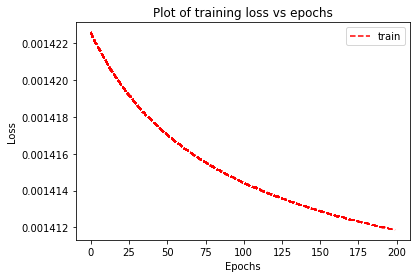

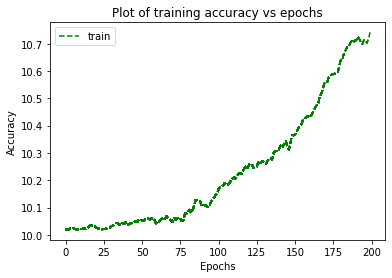

In [13]:
featLength = 2+5+2
# Initilaizing the model
model = perceptron(featLength).to(device)
criterion = nn.MSELoss() 
model = train_model(model,criterion,num_epochs=200,learning_rate=1) # Training the model

**Performance evaluation of trained perceptron**

In [12]:
# Finding testing accuracy
test_running_corr = 0
# Loading data in batches
batches = 0
testLabels = []

model.eval() # Testing the model in evaluation mode

for tsData in tqdm.tqdm_notebook(testLoader):
    inputs,labels = tsData
    
    inputs, labels = inputs.float().to(device),labels.float()      
    
    with torch.no_grad(): # No back-propagation during testing; gradient computation is not required
        
        # Feedforward train data batch through model
        output = model(inputs) 
        # Predicted class is the one with maximum probability
        _,preds = output.data.max(1)    
        if batches==0:
            totalPreds = preds
            testLabels = torch.argmax(labels,dim=1) # Converting 1-hot vector labels to integer labels
            batches = 1
        else:
            totalPreds = torch.cat((totalPreds,preds),0)
            testLabels = torch.cat((testLabels,torch.argmax(labels,dim=1)),0) 

# Finding total number of correct predictions
ts_corr = np.sum(np.equal(totalPreds.cpu().numpy(),testLabels.numpy()))
# Calculating accuracy
ts_acc = ts_corr/testLabels.shape[0]
print('Accuracy on test set = '+str(ts_acc*100)+'%')

<ipython-input-12-36d60e0dc82d>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for tsData in tqdm.tqdm_notebook(testLoader):


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on test set = 9.98%
